## Эксперименты с аугментациями на SVHN

- **Часть 1. Постепенное добавление аугментаций (SimpleCNN)** — сравнение 5 стадий аугментаций при фиксированном соотношении данных
- **Часть 2. Исследование доли аугментированных данных** — матрица результатов F1 в зависимости от стадии и `p_aug`
- **Часть 3. Анализ лучших конфигураций** — learning curves, confusion matrix и F1 по классам
- **Часть 4. Модель ResNet18Cifar** — те же эксперименты для более мощной архитектуры
- **Часть 5. Подбор гиперпараметров (Optuna)** — поиск `lr`, `weight_decay`, `p_aug` и типа scheduler для ResNet
- **Часть 6. Финальное дообучение ResNet18Cifar** — обучение лучшей конфигурации на 15 эпох
- **Часть 7. Knowledge Distillation** — перенос знаний с ResNet18Cifar на компактную SimpleCNN и сравнение моделей

Во всех экспериментах используется датасет **SVHN**, метрика **F1‑score (macro)** и фиксированный random seed

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm.auto import tqdm
from config import DATA_DIR, MODELS_DIR, REPORTS_DIR, RANDOM_SEED, NUM_WORKERS, BATCH_SIZE, VAL_FRACTION, EPOCHS, LR, WEIGHT_DECAY
from data_loading import set_seed, get_svhn_for_eda, compute_channel_stats, get_dataloaders_with_custom_train_transform
from model import SimpleCNN, ResNet18Cifar
from augmentations import get_eval_transform, stage1_basic, stage2_geometry, stage3_color, stage4_blur_noise, stage5_occlusion, ProbTransform
from training import train_epoch, eval_epoch, fit, evaluate
from visualization import plot_confusion_matrix
from pathlib import Path
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import json, re
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import SVHN
import pandas as pd
import torch.nn.functional as F

### Подготовка окружения и фиксирование случайности

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
set_seed(RANDOM_SEED)
print("Device:", device)

Device: mps


In [3]:
train_eda, _ = get_svhn_for_eda(str(DATA_DIR))
mean, std = compute_channel_stats(train_eda, batch_size=384, num_workers=NUM_WORKERS)
print("mean:", [round(v,4) for v in mean], "std:", [round(v,4) for v in std])

eval_t = get_eval_transform(mean, std)

mean: [0.4377, 0.4438, 0.4728] std: [0.1977, 0.2007, 0.1966]


`eval_t` — базовый трансформ без аугментаций, который используется для валидации и теста во всех последующих экспериментах

### Вспомогательные функции для конфигов, путей и сохранения результатов

In [ ]:
def cfg_id_stage(stage_name: str) -> str:
    return f"stage_{stage_name}"

def cfg_id_ratio(stage_name: str, r: float) -> str:
    return f"stage_{stage_name}_p{r:.2f}"

def model_path_of(cfg_id: str) -> Path:
    return Path(MODELS_DIR) / f"{cfg_id}.pth"

def metrics_path_of(cfg_id: str) -> Path:
    return Path(REPORTS_DIR) / f"{cfg_id}_metrics.json"

def history_path_of(cfg_id: str) -> Path:
    return Path(REPORTS_DIR) / f"{cfg_id}_history.json"

def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def load_json(path: Path):
    with open(path, "r") as f:
        return json.load(f)
    
def train_or_load_generic(cfg_id: str, model_cls, model_name: str,
                          train_loader, val_loader, test_loader):
    ckpt = model_path_of(cfg_id)
    mpath = metrics_path_of(cfg_id)

    model = model_cls(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()

    if ckpt.exists() and mpath.exists():
        model.load_state_dict(torch.load(ckpt, map_location=device))
        return load_json(mpath)

    params_m = sum(p.numel() for p in model.parameters()) / 1e6
    optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    t0 = time.time()
    _ = fit(model, train_loader, val_loader, device, criterion, optimizer, epochs=EPOCHS)
    t1 = time.time()

    torch.save(model.state_dict(), ckpt)

    test_metrics, _, _, _ = evaluate(model, test_loader, device, criterion)
    sec_per_epoch = (t1 - t0) / max(1, EPOCHS)
    imgs_per_epoch = len(train_loader.dataset)
    img_per_s = imgs_per_epoch / sec_per_epoch

    test_metrics.update({
        "model_name": model_name,
        "params_m": round(params_m, 3),
        "sec_per_epoch": round(sec_per_epoch, 3),
        "img_per_s": round(img_per_s, 1),
        "epochs": EPOCHS,
    })
    save_json(test_metrics, mpath)
    return test_metrics

## Часть 1. Постепенное добавление аугментаций (SimpleCNN)


5 стадий аугментаций:
- `stage1_basic` — базовые геометрические преобразования (горизонтальный флип, небольшие повороты)
- `stage2_geometry` — зумы и сдвиги
- `stage3_color` — изменения яркости и контраста
- `stage4_blur_noise` — размытие и шум
- `stage5_occlusion` — окклюзии

Для каждой стадии:
1. Собирается `train_loader` с соответствующей цепочкой аугментаций
2. Обучается SimpleCNN (или загружается уже обученная модель)
3. Считается тестовый F1‑score (macro)

In [5]:
stages = {
    "stage1_basic": stage1_basic,
    "stage2_geometry": stage2_geometry,
    "stage3_color": stage3_color,
    "stage4_blur_noise": stage4_blur_noise,
    "stage5_occlusion": stage5_occlusion,
}
results_stages = {}

for name, builder in stages.items():
    print(f"\n=== {name} ===")
    cfg_id = cfg_id_stage(name)
    ckpt = model_path_of(cfg_id)
    mpath = metrics_path_of(cfg_id)

    train_t = builder(mean, std)
    train_loader, val_loader, test_loader = get_dataloaders_with_custom_train_transform(
        data_root=str(DATA_DIR),
        train_transform=train_t,
        eval_transform=eval_t,
        batch_size=BATCH_SIZE,
        val_fraction=VAL_FRACTION,
        seed=RANDOM_SEED,
        num_workers=NUM_WORKERS,
    )

    model = SimpleCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()

    if ckpt.exists() and mpath.exists():
        model.load_state_dict(torch.load(ckpt, map_location=device))
        test_metrics = load_json(mpath)
        print(f"\nTest F1 (macro): {test_metrics['f1_macro']:.4f}")
    else:
        optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        _ = fit(model, train_loader, val_loader, device, criterion, optimizer, epochs=EPOCHS)
        torch.save(model.state_dict(), ckpt)

        test_metrics, y_true, y_pred, cm = evaluate(model, test_loader, device, criterion)
        save_json(test_metrics, mpath)
        print(f"\nTest F1 (macro): {test_metrics['f1_macro']:.4f}")

    results_stages[name] = test_metrics


=== stage1_basic ===

Test F1 (macro): 0.8979

=== stage2_geometry ===

Test F1 (macro): 0.8899

=== stage3_color ===

Test F1 (macro): 0.8890

=== stage4_blur_noise ===

Test F1 (macro): 0.8757

=== stage5_occlusion ===

Test F1 (macro): 0.8687


Видно, что слишком агрессивные стадии немного ухудшают F1 по сравнению с базовыми

## Часть 2. Исследование доли аугментированных данных `p_aug` (SimpleCNN)

Для каждой стадии аугментаций берутся:
- `aug_t` — трансформ со стадией (аугментированные изображения)
- `base_t` (`eval_t`) — чистые изображения без аугментаций

С помощью `ProbTransform` строится смешанный трансформ: с вероятностью `p_aug` применяется `aug_t`, с вероятностью `1 - p_aug` — базовый `eval_t`. Перебираются `p_aug` $\in$ {0.0, 0.25, 0.5, 0.75, 1.0} и для каждой пары (стадия, `p_aug`) обучается SimpleCNN через `train_or_load_generic`

In [6]:
ratios = [0.0, 0.25, 0.50, 0.75, 1.0]
results_grid = {}

for stage_name, stage_builder in stages.items():
    print(f"\n==== Stage: {stage_name} ==== \n")
    results_grid[stage_name] = {}
    for r in ratios:
        aug_t = stage_builder(mean, std)
        base_t = eval_t
        prob_t = ProbTransform(base_t=base_t, aug_t=aug_t, p_aug=r)

        train_loader, val_loader, test_loader = get_dataloaders_with_custom_train_transform(
            data_root=str(DATA_DIR),
            train_transform=prob_t,
            eval_transform=eval_t,
            batch_size=BATCH_SIZE,
            val_fraction=VAL_FRACTION,
            seed=RANDOM_SEED,
            num_workers=NUM_WORKERS,
        )

        cfg_id = cfg_id_ratio(stage_name, r)
        test_metrics = train_or_load_generic(
            cfg_id, SimpleCNN, "simplecnn",
            train_loader, val_loader, test_loader
        )
        print(f"  -- p_aug={r:.2f}: Test F1 (macro) = {test_metrics['f1_macro']:.4f}")
        results_grid[stage_name][r] = test_metrics


==== Stage: stage1_basic ==== 

  -- p_aug=0.00: Test F1 (macro) = 0.9290
  -- p_aug=0.25: Test F1 (macro) = 0.9217
  -- p_aug=0.50: Test F1 (macro) = 0.9128
  -- p_aug=0.75: Test F1 (macro) = 0.9184
  -- p_aug=1.00: Test F1 (macro) = 0.8900

==== Stage: stage2_geometry ==== 

  -- p_aug=0.00: Test F1 (macro) = 0.9138
  -- p_aug=0.25: Test F1 (macro) = 0.9262
  -- p_aug=0.50: Test F1 (macro) = 0.9131
  -- p_aug=0.75: Test F1 (macro) = 0.9075
  -- p_aug=1.00: Test F1 (macro) = 0.8761

==== Stage: stage3_color ==== 

  -- p_aug=0.00: Test F1 (macro) = 0.9126
  -- p_aug=0.25: Test F1 (macro) = 0.9218
  -- p_aug=0.50: Test F1 (macro) = 0.9183
  -- p_aug=0.75: Test F1 (macro) = 0.9124
  -- p_aug=1.00: Test F1 (macro) = 0.8941

==== Stage: stage4_blur_noise ==== 

  -- p_aug=0.00: Test F1 (macro) = 0.9225
  -- p_aug=0.25: Test F1 (macro) = 0.9251
  -- p_aug=0.50: Test F1 (macro) = 0.9150
  -- p_aug=0.75: Test F1 (macro) = 0.9023
  -- p_aug=1.00: Test F1 (macro) = 0.8694

==== Stage: stage5_

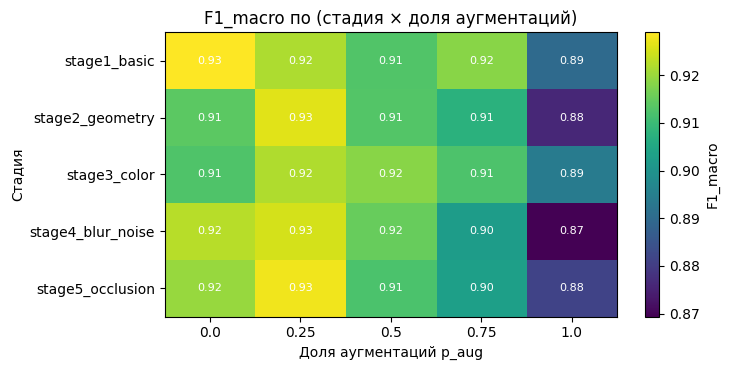

In [7]:
stage_names = list(results_grid.keys())
rs = sorted(ratios)
mat = np.array([[results_grid[s][r]["f1_macro"] for r in rs] for s in stage_names])

plt.figure(figsize=(7.5, 3.8))
im = plt.imshow(mat, cmap="viridis", aspect="auto")
plt.colorbar(im, label="F1_macro")
plt.xticks(range(len(rs)), [str(r) for r in rs])
plt.yticks(range(len(stage_names)), stage_names)
plt.xlabel("Доля аугментаций p_aug")
plt.ylabel("Стадия")
plt.title("F1_macro по (стадия × доля аугментаций)")
for i in range(len(stage_names)):
    for j in range(len(rs)):
        plt.text(j, i, f"{mat[i,j]:.2f}", va="center", ha="center", color="w", fontsize=8)
plt.tight_layout()
plt.show()

Видно, что во всех стадиях наилучшее качество дает умеренная доля аугментаций (`p_aug`  $\approx$ 0.0–0.25), при полном использовании аугментаций (`p_aug` = 1.0) F1 падает. При этом различия между самими стадиями относительно небольшие, а самые высокие значения F1 наблюдаются для `stage2_geometry`, `stage4_blur_noise` и `stage5_occlision` при `p_aug = 0.25`.

## Часть 3. Анализ лучших конфигураций

In [8]:
def train_with_history_once(cfg_id: str, train_loader, val_loader, device, epochs: int):
    ckpt = model_path_of(cfg_id)
    hpath = history_path_of(cfg_id)

    model = SimpleCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()

    if ckpt.exists() and hpath.exists():
        model.load_state_dict(torch.load(ckpt, map_location=device))
        history = load_json(hpath)
        return model, history

    optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    history = {"train": {"loss": [], "accuracy": [], "f1_macro": []},
               "val":   {"loss": [], "accuracy": [], "f1_macro": []}}

    best_f1, best_state = -1.0, None
    for epoch in range(1, epochs+1):
        tr,_,_ = train_epoch(model, train_loader, device, criterion, optimizer)
        va,_,_ = eval_epoch(model, val_loader, device, criterion)
        for k in ["loss","accuracy","f1_macro"]:
            history["train"][k].append(tr[k])
            history["val"][k].append(va[k])
        if va["f1_macro"] > best_f1:
            best_f1 = va["f1_macro"]
            best_state = {k: v.detach().cpu() for k,v in model.state_dict().items()}
        print(f"Epoch {epoch:02d} | Train loss={tr['loss']:.4f} acc={tr['accuracy']:.4f} f1={tr['f1_macro']:.4f} | "
              f"Val loss={va['loss']:.4f} acc={va['accuracy']:.4f} f1={va['f1_macro']:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    torch.save(model.state_dict(), ckpt)
    save_json(history, hpath)
    return model, history

def plot_learning_curves(history, title_prefix):
    epochs = range(1, len(history["train"]["loss"])+1)

    plt.figure(figsize=(11,3))
    plt.subplot(1,3,1)
    plt.plot(epochs, history["train"]["loss"], label="train")
    plt.plot(epochs, history["val"]["loss"], label="val")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, history["train"]["accuracy"], label="train")
    plt.plot(epochs, history["val"]["accuracy"], label="val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,3,3)
    if "f1_macro" in history.get("train", {}):
        plt.plot(epochs, history["train"]["f1_macro"], label="train")
    plt.plot(epochs, history["val"]["f1_macro"], label="val")
    plt.title("F1 (macro)")
    plt.legend()
    plt.suptitle(title_prefix)
    plt.tight_layout()
    plt.show()

In [9]:
pairs = []
for s in results_grid:
    for r, metrics in results_grid[s].items():
        pairs.append((s, r, metrics["f1_macro"]))
top2 = sorted(pairs, key=lambda t: t[2], reverse=True)[:2]
print("Top-2 configs:", top2)

Top-2 configs: [('stage1_basic', 0.0, 0.9289640898974267), ('stage5_occlusion', 0.25, 0.9275989614828019)]


In [10]:
def plot_per_class_f1(y_true, y_pred, title="Per-class F1"):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=list(range(10)))
    per_class_f1 = [report[str(c)]["f1-score"] for c in range(10)]
    plt.figure(figsize=(7,4))
    sns.barplot(x=[str(i) for i in range(10)], y=per_class_f1, color="#1f77b4")
    plt.ylim(0.85,1.0)
    plt.xlabel("класс")
    plt.ylabel("F1")
    plt.title(title)
    plt.tight_layout()
    plt.show()


=== stage1_basic | p_aug=0.00 | F1_macro(saved)=0.9290 ===


Val:   0%|          | 0/68 [00:05<?, ?it/s]

Test metrics:
  loss: 0.2316
  accuracy: 0.9340
  precision_macro: 0.9317
  recall_macro: 0.9260
  f1_macro: 0.9282
  precision_weighted: 0.9349
  recall_weighted: 0.9340
  f1_weighted: 0.9338


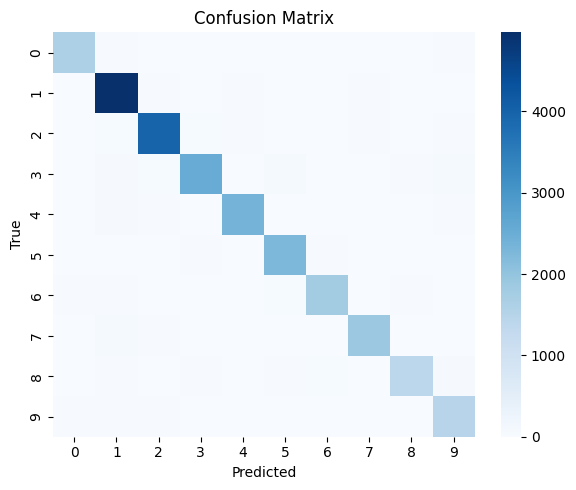

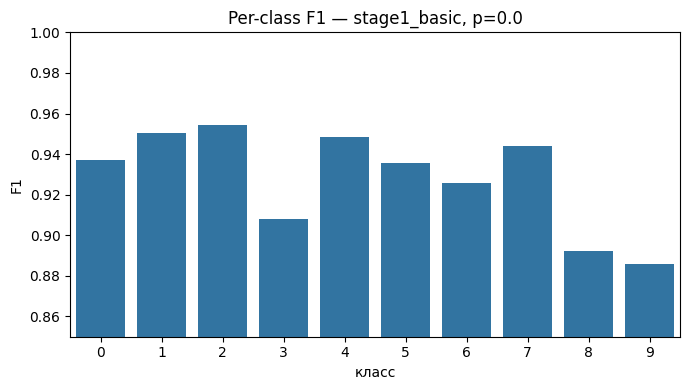


=== stage5_occlusion | p_aug=0.25 | F1_macro(saved)=0.9276 ===


Val:   0%|          | 0/68 [00:05<?, ?it/s]

Test metrics:
  loss: 0.2470
  accuracy: 0.9314
  precision_macro: 0.9288
  recall_macro: 0.9257
  f1_macro: 0.9266
  precision_weighted: 0.9325
  recall_weighted: 0.9314
  f1_weighted: 0.9314


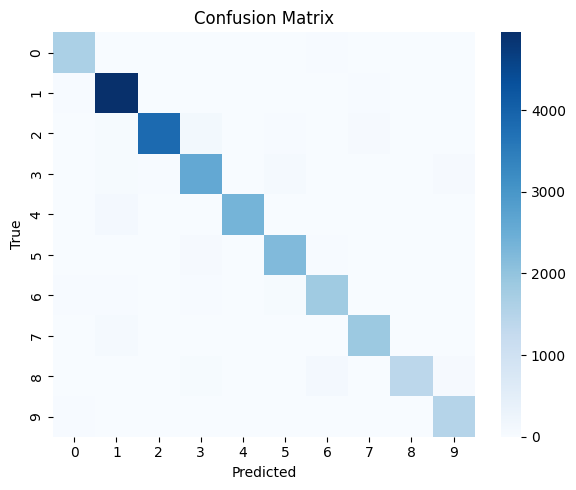

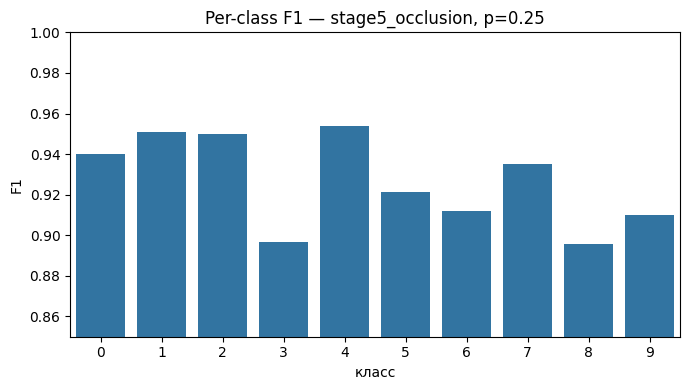

In [ ]:
for stage_name, ratio, f1 in top2:
    print(f"\n=== {stage_name} | p_aug={ratio:.2f} | F1_macro(saved)={f1:.4f} ===")
    aug_t  = stages[stage_name](mean, std)
    base_t = eval_t
    prob_t = ProbTransform(base_t=base_t, aug_t=aug_t, p_aug=ratio)
    train_loader, val_loader, test_loader = get_dataloaders_with_custom_train_transform(
        data_root=str(DATA_DIR),
        train_transform=prob_t,
        eval_transform=eval_t,
        batch_size=BATCH_SIZE,
        val_fraction=VAL_FRACTION,
        seed=RANDOM_SEED,
        num_workers=NUM_WORKERS,
    )

    cfg_id = cfg_id_ratio(stage_name, ratio)
    ckpt = model_path_of(cfg_id)
    model = SimpleCNN(num_classes=10).to(device)
    model.load_state_dict(torch.load(ckpt, map_location=device))
    criterion = nn.CrossEntropyLoss()
    test_metrics, y_true, y_pred, cm = evaluate(model, test_loader, device, criterion)

    print("Test metrics:")
    for k in ["loss","accuracy","precision_macro","recall_macro","f1_macro","precision_weighted","recall_weighted","f1_weighted"]:
        print(f"  {k}: {test_metrics[k]:.4f}")

    plot_confusion_matrix(cm, class_names=[str(i) for i in range(10)])
    plot_per_class_f1(y_true, y_pred, title=f"Per-class F1 — {stage_name}, p={ratio}")

Для stage1_basic, p_aug = 0.0 матрица почти диагональная, а F1 по классам держится в районе 0.93–0.96, чуть хуже распознаются классы 3, 8 и 9, но разброс небольшой

Для stage5_occlusion, p_aug = 0.25 качество очень близко к базовой конфигурации: диагональ всё ещё доминирует, но ошибки немного чаще, а самые сложные классы — 3, 6, 8 и 9

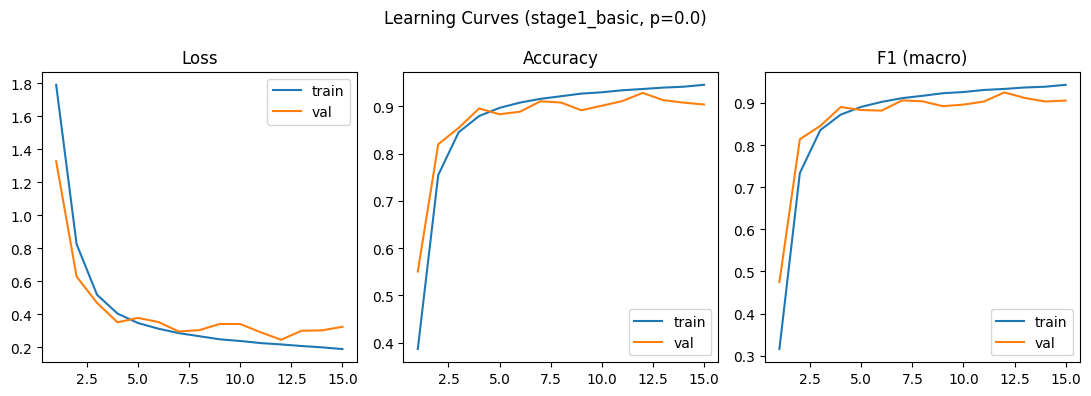

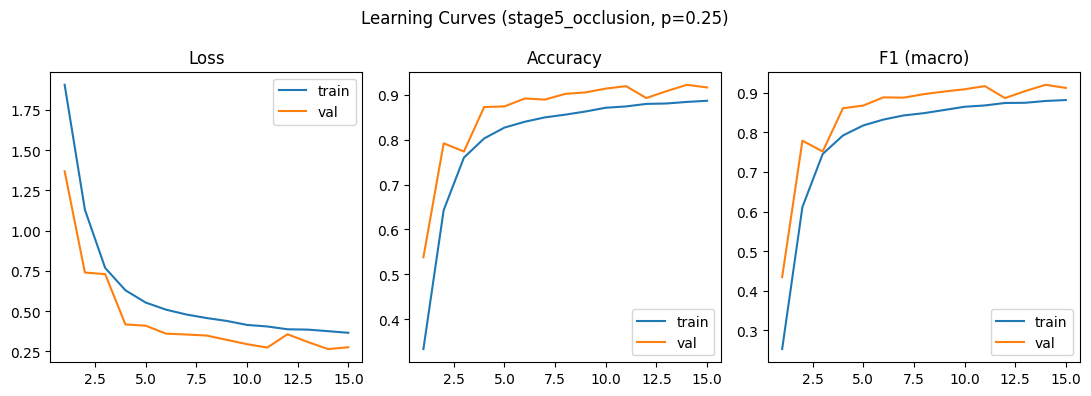

In [ ]:
model_curves = []
for stage_name, ratio, _ in top2:
    aug_t  = stages[stage_name](mean, std)
    base_t = eval_t
    prob_t = ProbTransform(base_t=base_t, aug_t=aug_t, p_aug=ratio)
    train_loader, val_loader, test_loader = get_dataloaders_with_custom_train_transform(
        data_root=str(DATA_DIR),
        train_transform=prob_t,
        eval_transform=eval_t,
        batch_size=BATCH_SIZE,
        val_fraction=VAL_FRACTION,
        seed=RANDOM_SEED,
        num_workers=NUM_WORKERS,
    )

    cfg_id = cfg_id_ratio(stage_name, ratio)
    model, history = train_with_history_once(cfg_id, train_loader, val_loader, device, epochs=EPOCHS)
    plot_learning_curves(history, title_prefix=f"Learning Curves ({stage_name}, p={ratio})")

Для stage1_basic, p_aug = 0.0 loss на train/val монотонно падает, accuracy и F1 быстро выходят на плато $\approx$ 0.9+, при этом заметного переобучения не видно — кривые train и val идут близко друг к другу

Для stage5_occlusion, p_aug = 0.25 динамика похожая: качество растет, а train и val‑кривые также остаются близкими, что говорит об отсутствии сильного переобучения несмотря на более агрессивные аугментации

## Часть 4. Эксперименты с ResNet18Cifar

Здесь повторяется идея Части 2, но для архитектуры **ResNet18Cifar**

In [12]:
EPOCHS_RESNET = 5
_prev_epochs = EPOCHS
EPOCHS = EPOCHS_RESNET

In [ ]:
def cfg_id_ratio_resnet(stage_name: str, r: float) -> str:
    return f"resnet18cifar_stage_{stage_name}_p{r:.2f}"

results_grid_resnet = {}

for stage_name, stage_builder in stages.items():
    print(f"\n==== Stage: {stage_name} ====")
    results_grid_resnet[stage_name] = {}
    for r in ratios:
        aug_t = stage_builder(mean, std)
        base_t = eval_t
        prob_t = ProbTransform(base_t=base_t, aug_t=aug_t, p_aug=r)

        train_loader, val_loader, test_loader = get_dataloaders_with_custom_train_transform(
            data_root=str(DATA_DIR),
            train_transform=prob_t,
            eval_transform=eval_t,
            batch_size=BATCH_SIZE,
            val_fraction=VAL_FRACTION,
            seed=RANDOM_SEED,
            num_workers=NUM_WORKERS,
        )

        cfg_id = cfg_id_ratio_resnet(stage_name, r)
        test_metrics = train_or_load_generic(
            cfg_id, ResNet18Cifar, "resnet18cifar",
            train_loader, val_loader, test_loader
        )
        print(f"  p_aug={r:.2f}: F1_macro={test_metrics['f1_macro']:.4f}")
        results_grid_resnet[stage_name][r] = test_metrics


==== Stage: stage1_basic ====
  p_aug=0.00: F1_macro=0.9064
  p_aug=0.25: F1_macro=0.9307
  p_aug=0.50: F1_macro=0.9090
  p_aug=0.75: F1_macro=0.9159
  p_aug=1.00: F1_macro=0.9167

==== Stage: stage2_geometry ====
  p_aug=0.00: F1_macro=0.9118
  p_aug=0.25: F1_macro=0.9069
  p_aug=0.50: F1_macro=0.9065
  p_aug=0.75: F1_macro=0.9014
  p_aug=1.00: F1_macro=0.9051

==== Stage: stage3_color ====
  p_aug=0.00: F1_macro=0.9170
  p_aug=0.25: F1_macro=0.9266
  p_aug=0.50: F1_macro=0.9165
  p_aug=0.75: F1_macro=0.9256
  p_aug=1.00: F1_macro=0.8800

==== Stage: stage4_blur_noise ====
  p_aug=0.00: F1_macro=0.9188
  p_aug=0.25: F1_macro=0.9236
  p_aug=0.50: F1_macro=0.9244
  p_aug=0.75: F1_macro=0.9114
  p_aug=1.00: F1_macro=0.9105

==== Stage: stage5_occlusion ====
  p_aug=0.00: F1_macro=0.9249
  p_aug=0.25: F1_macro=0.9194
  p_aug=0.50: F1_macro=0.9144
  p_aug=0.75: F1_macro=0.9114
  p_aug=1.00: F1_macro=0.9094


In [14]:
EPOCHS = _prev_epochs

### Полное обучение лучшей конфигурации ResNet18Cifar

Top-1 ResNet: stage1_basic 0.25


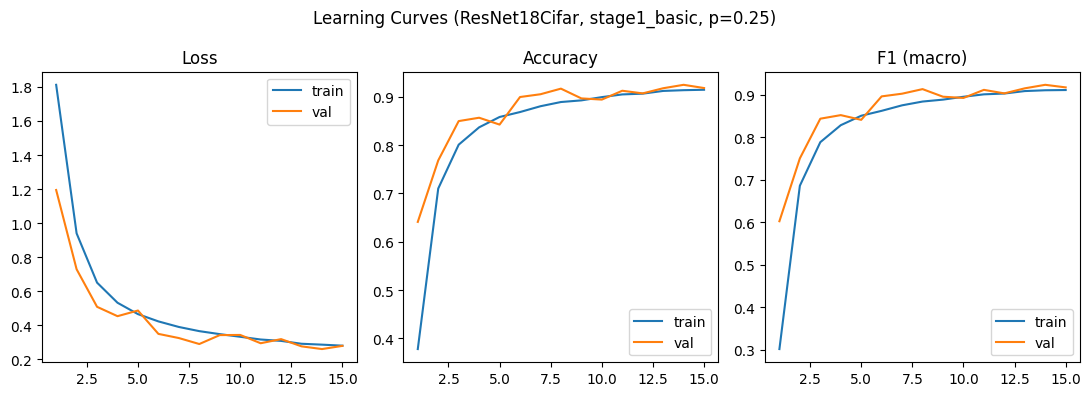

In [ ]:
best_stage, best_ratio, _ = max(
    ((s, r, m["f1_macro"]) for s, d in results_grid_resnet.items() for r, m in d.items()),
    key=lambda t: t[2]
)
print("Top-1 ResNet:", best_stage, best_ratio)

EPOCHS_FULL = 15
_prev_epochs = EPOCHS
EPOCHS = EPOCHS_FULL

def cfg_id_ratio_resnet_full(stage_name: str, r: float) -> str:
    return f"resnet18cifar_e{EPOCHS_FULL}_stage_{stage_name}_p{r:.2f}"

aug_t = stages[best_stage](mean, std)
base_t = eval_t
prob_t = ProbTransform(base_t=base_t, aug_t=aug_t, p_aug=best_ratio)
train_loader, val_loader, test_loader = get_dataloaders_with_custom_train_transform(
    data_root=str(DATA_DIR),
    train_transform=prob_t,
    eval_transform=eval_t,
    batch_size=BATCH_SIZE,
    val_fraction=VAL_FRACTION,
    seed=RANDOM_SEED,
    num_workers=NUM_WORKERS,
)

cfg_id = cfg_id_ratio_resnet_full(best_stage, best_ratio)
model, history = train_with_history_once(cfg_id, train_loader, val_loader, device, epochs=EPOCHS_FULL)
plot_learning_curves(history, f"Learning Curves (ResNet18Cifar, {best_stage}, p={best_ratio})")

Для ResNet18Cifar (stage1_basic, p_aug = 0.25) loss на train и val стабильно снижается, accuracy и F1 быстро выходят на плато $\approx$ 0.9+, при этом кривые train/val практически совпадают — явного переобучения нет

Val:   0%|          | 0/68 [00:05<?, ?it/s]

ResNet (full) test F1_macro: 0.9292


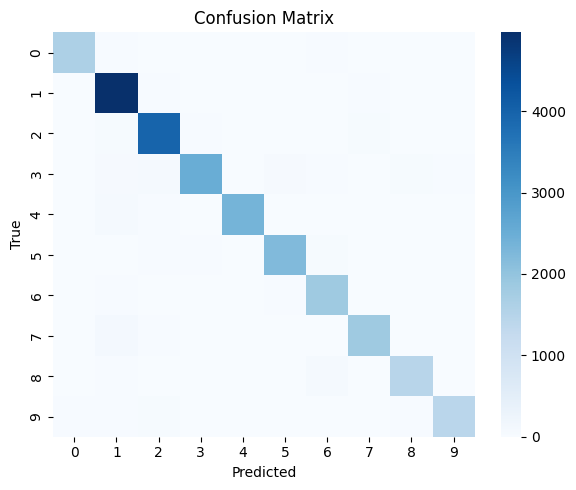

In [16]:
criterion = nn.CrossEntropyLoss()
test_metrics, y_true, y_pred, cm = evaluate(model, test_loader, device, criterion)
print("ResNet (full) test F1_macro:", round(test_metrics["f1_macro"], 4))
plot_confusion_matrix(cm, class_names=[str(i) for i in range(10)])

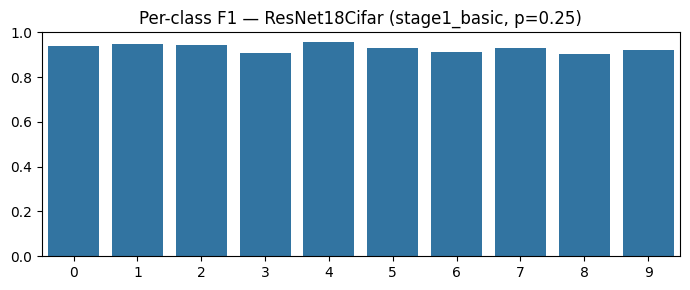

In [ ]:
rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=list(range(10)))
f1s = [rep[str(c)]["f1-score"] for c in range(10)]
plt.figure(figsize=(7,3))
sns.barplot(x=[str(i) for i in range(10)], y=f1s, color="#1f77b4")
plt.ylim(0,1.0)
plt.title(f"Per-class F1 — ResNet18Cifar ({best_stage}, p={best_ratio})")
plt.tight_layout()
plt.show()


Confusion matrix близка к диагонали, а per‑class F1 почти одинаков для всех цифр ($\approx$ 0.9–0.95), что говорит о равномерном качестве по классам

Итоговый `F1_macro = 0.9292` немного выше лучшией конфигурации SimpleCNN

In [ ]:
EPOCHS = _prev_epochs

### Сводная таблица запусков (SimpleCNN и ResNet18Cifar)

In [ ]:
rows = []
for p in Path(REPORTS_DIR).glob("*_metrics.json"):
    m = json.loads(p.read_text())
    s = p.stem 
    
    model = m.get("model_name")
    if not model:
        model = "resnet18cifar" if s.startswith("resnet18cifar") else "simplecnn"

    f1  = m.get("f1_macro")
    acc = m.get("accuracy")
    params = m.get("params_m")
    sec = m.get("sec_per_epoch")
    eps = m.get("epochs")

    stage_m = re.search(r"stage_(.+?)_p", s)
    ratio_m = re.search(r"_p(\d+\.\d+)", s)
    e_m = re.search(r"_e(\d+)_", s)

    rows.append({
        "model": model,
        "stage": stage_m.group(1) if stage_m else "",
        "p_aug": float(ratio_m.group(1)) if ratio_m else None,
        "f1_macro": f1,
        "accuracy": acc,
        "params_m": params,
        "sec_per_epoch": sec,
        "epochs": eps if eps is not None else (int(e_m.group(1)) if e_m else 15),
    })

df = pd.DataFrame(rows)
display(df.sort_values(["f1_macro"], ascending=False).head(20))

,model,stage,p_aug,f1_macro,accuracy,params_m,sec_per_epoch,epochs
50,resnet18cifar,stage1_basic,0.25,0.930675,0.932852,11.174,1291.321,5
33,resnet18cifar,stage1_basic,0.25,0.929236,0.932852,11.174,836.203,15
1,simplecnn,stage1_basic,0.00,0.928964,0.934235,NaN,NaN,15
18,simplecnn,stage5_occlusion,0.25,0.927599,0.932967,NaN,NaN,15
0,resnet18cifar,stage3_color,0.25,0.926610,0.930624,11.174,1720.158,5
35,simplecnn,stage2_geometry,0.25,0.926205,0.929087,NaN,NaN,15
49,resnet18cifar,stage3_color,0.75,0.925612,0.930624,11.174,1480.346,5
12,simplecnn,stage4_blur_noise,0.25,0.925090,0.930163,NaN,NaN,15
11,resnet18cifar,stage5_occlusion,0.00,0.924852,0.929126,11.174,749.681,5
29,resnet18cifar,stage4_blur_noise,0.50,0.924396,0.928357,11.174,1742.916,5


Наивысший F1_macro ($\approx$ 0.93) достигают конфигурации ResNet18Cifar со стадией `stage1_basic` и небольшой долей аугментаций (`p_aug` $\approx$ 0.25), тогда как лучшие варианты SimpleCNN немного уступают им по F1, но очень близки

## Часть 5. Подбор гиперпараметров ResNet с помощью Optuna

### Настройка Optuna‑поиска

Переменные для подбора:
- **learning rate** `lr`
- **weight decay** `weight_decay`
- доля аугментаций `p_aug`
- тип scheduler: `none`, `onecycle`, `cosine`

Функция `objective` обучает модель на несколько эпох (EPOCHS_TRIAL), возвращает лучшую val F1_macro за трейл

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts, SequentialLR, LambdaLR
from contextlib import nullcontext
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

EPOCHS_TRIAL = 3
N_TRIALS = 6  

def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    p_aug = trial.suggest_float("p_aug", 0.0, 1.0)
    scheduler_type = trial.suggest_categorical("scheduler", ["none", "onecycle", "cosine"])

    stage_name = best_stage
    aug_t = stages[stage_name](mean, std)
    prob_t = ProbTransform(base_t=eval_t, aug_t=aug_t, p_aug=p_aug)

    train_loader, val_loader, _ = get_dataloaders_with_custom_train_transform(
        data_root=str(DATA_DIR),
        train_transform=prob_t,
        eval_transform=eval_t,
        batch_size=BATCH_SIZE,
        val_fraction=VAL_FRACTION,
        seed=RANDOM_SEED,
        num_workers=0,
    )

    model = ResNet18Cifar(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)

    if scheduler_type == "onecycle":
        scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=EPOCHS_TRIAL, steps_per_epoch=len(train_loader),
                               pct_start=0.1, div_factor=25.0)
        sched_step_per_batch = True
    elif scheduler_type == "cosine":
        warmup = LambdaLR(optimizer, lr_lambda=lambda e: min(1.0, (e+1)/1))  # 1 эпоха разогрева
        cosine = CosineAnnealingWarmRestarts(optimizer, T_0=max(2, EPOCHS_TRIAL-1))
        scheduler = SequentialLR(optimizer, [warmup, cosine], milestones=[1])
        sched_step_per_batch = False
    else:
        scheduler = None
        sched_step_per_batch = False

    amp_ctx = nullcontext()
    best_val_f1 = 0.0

    for ep in range(EPOCHS_TRIAL):
        model.train()
        for x, y in train_loader:
            x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with amp_ctx:
                logits = model(x)
                loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            if scheduler and sched_step_per_batch:
                scheduler.step()

        val_metrics, _, _ = eval_epoch(model, val_loader, device, criterion)
        best_val_f1 = max(best_val_f1, val_metrics["f1_macro"])
        if scheduler and not sched_step_per_batch:
            scheduler.step()

    return best_val_f1

In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="svhn-resnet",
    storage="sqlite:///reports/optuna.db",
    load_if_exists=True,
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=1)  # режет слабые трейлы раньше
)

print("completed:", len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]))
print("best:", study.best_value, study.best_params if len(study.trials) else None)

study.optimize(objective, n_trials=N_TRIALS)
print("Best:", study.best_value, study.best_params)
best = study.best_params

[I 2025-10-25 01:51:35,102] Using an existing study with name 'svhn-resnet' instead of creating a new one.


completed: 31
best: 0.8057156727380663 {'lr': 0.0008418495235483918, 'weight_decay': 8.295878265006422e-06, 'p_aug': 0.07146797180101172, 'scheduler': 'onecycle'}


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-25 04:53:46,030] Trial 33 finished with value: 0.7629320553343286 and parameters: {'lr': 0.00083093394492283, 'weight_decay': 0.000624213805993791, 'p_aug': 0.007547319316293211, 'scheduler': 'onecycle'}. Best is trial 5 with value: 0.8057156727380663.


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:01<?, ?it/s]

[I 2025-10-25 06:05:59,600] Trial 34 finished with value: 0.7958216895334822 and parameters: {'lr': 0.0010440447577011198, 'weight_decay': 0.0001176904492659164, 'p_aug': 0.0606304379063997, 'scheduler': 'onecycle'}. Best is trial 5 with value: 0.8057156727380663.


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-25 06:39:10,067] Trial 35 finished with value: 0.8072173999776355 and parameters: {'lr': 0.001027915248626565, 'weight_decay': 0.0009814895495252535, 'p_aug': 0.04490250966651249, 'scheduler': 'onecycle'}. Best is trial 35 with value: 0.8072173999776355.


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-25 07:15:42,732] Trial 36 finished with value: 0.3265273002729695 and parameters: {'lr': 0.00103825554680562, 'weight_decay': 0.0009648692557963275, 'p_aug': 0.06782026776262118, 'scheduler': 'onecycle'}. Best is trial 35 with value: 0.8072173999776355.


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-25 07:46:29,491] Trial 37 finished with value: 0.11609677577356133 and parameters: {'lr': 0.0017398361532067435, 'weight_decay': 0.0005048381636030456, 'p_aug': 0.05094101390470096, 'scheduler': 'onecycle'}. Best is trial 35 with value: 0.8072173999776355.


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-10-25 09:35:15,729] Trial 38 finished with value: 0.1274854255941224 and parameters: {'lr': 0.000745438826546542, 'weight_decay': 0.00023578023415491003, 'p_aug': 0.012522232680287066, 'scheduler': 'onecycle'}. Best is trial 35 with value: 0.8072173999776355.


Best: 0.8072173999776355 {'lr': 0.001027915248626565, 'weight_decay': 0.0009814895495252535, 'p_aug': 0.04490250966651249, 'scheduler': 'onecycle'}


In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="svhn-resnet",
    storage="sqlite:///reports/optuna.db",
    load_if_exists=True,
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=1)
)

print("completed:", len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]))
study.optimize(objective, n_trials=1)
print("Best:", study.best_value, study.best_params)
best = study.best_params

[I 2025-11-03 04:16:24,792] Using an existing study with name 'svhn-resnet' instead of creating a new one.


completed: 37


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Val:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-03 04:48:00,928] Trial 39 finished with value: 0.027152682181355026 and parameters: {'lr': 0.0026902660079702488, 'weight_decay': 0.00012578389235983658, 'p_aug': 0.9695371107878658, 'scheduler': 'none'}. Best is trial 35 with value: 0.8072173999776355.


Best: 0.8072173999776355 {'lr': 0.001027915248626565, 'weight_decay': 0.0009814895495252535, 'p_aug': 0.04490250966651249, 'scheduler': 'onecycle'}


## Часть 6. Финальное дообучение ResNet18Cifar с лучшими гиперпараметрами

Для лучшего набора гиперпараметров из Optuna:

- Реализован `train_full_resumeable`, который:
  - умеет дозапускаться (если веса/история уже есть — просто загружает),
  - при отсутствии чекпоинтов обучает модель до конца и сохраняет историю и метрики
- Используется ускоренная схема валидации:
  - `eval_epoch_fast` — быстрая оценка loss/accuracy на каждом эпохе,
  - полный расчёт F1 через `eval_epoch` делается реже (`full_eval_every`), чтобы не тормозить обучение

Обучается выбранная конфигурация ResNet18Cifar на 15 эпох

In [ ]:
def train_full_resumeable(
    cfg_id: str,
    model_cls,
    train_loader, val_loader, test_loader,
    device, epochs: int = 15, lr: float = LR, wd: float = WEIGHT_DECAY,
    full_eval_every: int = 1
):
    ckpt = model_path_of(cfg_id)
    hpth = history_path_of(cfg_id)
    mpth = metrics_path_of(cfg_id)

    if Path(ckpt).exists() and Path(hpth).exists() and Path(mpth).exists():
        model = model_cls(num_classes=10).to(device)
        model.load_state_dict(torch.load(ckpt, map_location=device))
        history = load_json(hpth)
        metrics = load_json(mpth)
        return model, history, metrics

    model = model_cls(num_classes=10).to(device)
    history = fit_full_fast(
        model, train_loader, val_loader, device,
        epochs=epochs, lr=lr, wd=wd, full_eval_every=full_eval_every
    )

    criterion = nn.CrossEntropyLoss()
    test_metrics, y_true, y_pred, cm = evaluate(model, test_loader, device, criterion)

    torch.save(model.state_dict(), ckpt)
    save_json(history, hpth)

    params_m = sum(p.numel() for p in model.parameters())/1e6
    test_metrics.update({
        "model_name": "resnet18cifar",
        "epochs": epochs,
        "params_m": round(params_m, 3),
        "note": "full_fast f1_each_epoch"
    })
    save_json(test_metrics, mpth)
    return model, history, test_metrics

In [ ]:
def build_full_loaders(train_transform, eval_transform, batch_size):
    nw, pin, pw = 0, False, False
    train_a = SVHN(root=str(DATA_DIR), split="train", download=True,  transform=train_transform)
    train_b = SVHN(root=str(DATA_DIR), split="train", download=False, transform=eval_transform)
    test = SVHN(root=str(DATA_DIR), split="test",  download=True,  transform=eval_transform)
    g = torch.Generator().manual_seed(RANDOM_SEED)
    n_val = int(len(train_a)*VAL_FRACTION); n_tr = len(train_a)-n_val
    idx = torch.randperm(len(train_a), generator=g).tolist()
    tr_idx, va_idx = idx[:n_tr], idx[n_tr:]
    tr = Subset(train_a, tr_idx); va = Subset(train_b, va_idx)
    train_loader = DataLoader(tr, batch_size=batch_size, shuffle=True,  num_workers=nw, pin_memory=pin, persistent_workers=pw, drop_last=True)
    val_loader   = DataLoader(va, batch_size=batch_size, shuffle=False, num_workers=nw, pin_memory=pin, persistent_workers=pw)
    test_loader  = DataLoader(test,batch_size=batch_size, shuffle=False, num_workers=nw, pin_memory=pin, persistent_workers=pw)
    return train_loader, val_loader, test_loader

In [ ]:
@torch.no_grad()
def eval_epoch_fast(model, loader, device, criterion):
    model.eval()
    total_loss = 0.0
    total_ok = 0
    total_n = 0
    for x,y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item()*y.size(0)
        total_ok += (logits.argmax(1)==y).sum().item()
        total_n += y.size(0)
    return {
        "loss": total_loss/max(1,total_n),
        "accuracy": total_ok/max(1,total_n),
    }

In [ ]:
def fit_full_fast(model, train_loader, val_loader, device, epochs=15, lr=LR, wd=WEIGHT_DECAY, full_eval_every=3):
    criterion = nn.CrossEntropyLoss()
    opt = Adam(model.parameters(), lr=lr, weight_decay=wd)
    history = {"train":{"loss":[],"accuracy":[]}, "val":{"loss":[],"accuracy":[],"f1_macro":[]}}
    for ep in range(1, epochs+1):
        model.train()
        total_loss=0.0; total_ok=0; total_n=0
        for x,y in train_loader:
            x=x.to(device, non_blocking=True); y=y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            logits = model(x); loss = criterion(logits, y)
            loss.backward(); opt.step()
            total_loss += loss.item()*y.size(0)
            total_ok   += (logits.argmax(1)==y).sum().item()
            total_n    += y.size(0)
        tr_loss = total_loss/max(1,total_n); tr_acc = total_ok/max(1,total_n)
        history["train"]["loss"].append(tr_loss); history["train"]["accuracy"].append(tr_acc)

        fast = eval_epoch_fast(model, val_loader, device, criterion)
        history["val"]["loss"].append(fast["loss"]); history["val"]["accuracy"].append(fast["accuracy"])

        if (ep % full_eval_every == 0) or (ep==epochs):
            full,_,_ = eval_epoch(model, val_loader, device, criterion)  # твоя функция с sklearn
            history["val"]["f1_macro"].append(full["f1_macro"])
        else:
            history["val"]["f1_macro"].append(np.nan)

        print(f"Epoch {ep:02d} | Train loss={tr_loss:.4f} acc={tr_acc:.4f} | Val loss={fast['loss']:.4f} acc={fast['accuracy']:.4f} f1={history['val']['f1_macro'][-1]}")
    return history

In [ ]:
best_p = float(best["p_aug"])
aug_t = stages[best_stage](mean, std)
prob_t = ProbTransform(base_t=eval_t, aug_t=aug_t, p_aug=best_p)

train_loader, val_loader, test_loader = build_full_loaders(prob_t, eval_t, batch_size=BATCH_SIZE)
cfg_id = f"resnet18cifar_full_stage_{best_stage}_p{best_p:.2f}"

model, history, test_metrics = train_full_resumeable(
    cfg_id, ResNet18Cifar,
    train_loader, val_loader, test_loader,
    device, epochs=15, lr=LR, wd=WEIGHT_DECAY, full_eval_every=1
)

print("Test F1_macro:", round(test_metrics["f1_macro"],4))

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01 | Train loss=1.4475 acc=0.5062 | Val loss=0.7721 acc=0.7657 f1=0.7052637811387678


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 02 | Train loss=0.5191 acc=0.8524 | Val loss=0.3795 acc=0.8814 f1=0.8844727590405339


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 03 | Train loss=0.3389 acc=0.8969 | Val loss=0.3811 acc=0.8788 f1=0.8936053549326406


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 04 | Train loss=0.3132 acc=0.9112 | Val loss=0.2550 acc=0.9252 f1=0.9243597684051797


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 05 | Train loss=0.3789 acc=0.8968 | Val loss=0.4273 acc=0.8709 f1=0.9174478705304348


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 06 | Train loss=0.2747 acc=0.9248 | Val loss=0.3166 acc=0.9031 f1=0.9044287499190895


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 07 | Train loss=0.2741 acc=0.9263 | Val loss=0.2946 acc=0.9175 f1=0.9156103324423832


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 08 | Train loss=0.2844 acc=0.9252 | Val loss=0.2235 acc=0.9347 f1=0.9318261730162873


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 09 | Train loss=0.2151 acc=0.9408 | Val loss=0.2553 acc=0.9345 f1=0.9305157116984532


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 | Train loss=0.2384 acc=0.9353 | Val loss=0.5761 acc=0.8311 f1=0.8508703160504568


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 | Train loss=0.2531 acc=0.9313 | Val loss=0.2566 acc=0.9281 f1=0.9243294282327049


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 | Train loss=0.3081 acc=0.9141 | Val loss=0.2868 acc=0.9167 f1=0.9310521080420718


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 | Train loss=0.3210 acc=0.9107 | Val loss=0.2216 acc=0.9380 f1=0.9356370675769623


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 | Train loss=0.1657 acc=0.9530 | Val loss=0.3404 acc=0.9050 f1=0.9302096935007214


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 | Train loss=0.1752 acc=0.9476 | Val loss=0.2337 acc=0.9335 f1=0.9314505426759145


Val:   0%|          | 0/68 [00:00<?, ?it/s]

Test F1_macro: 0.9318


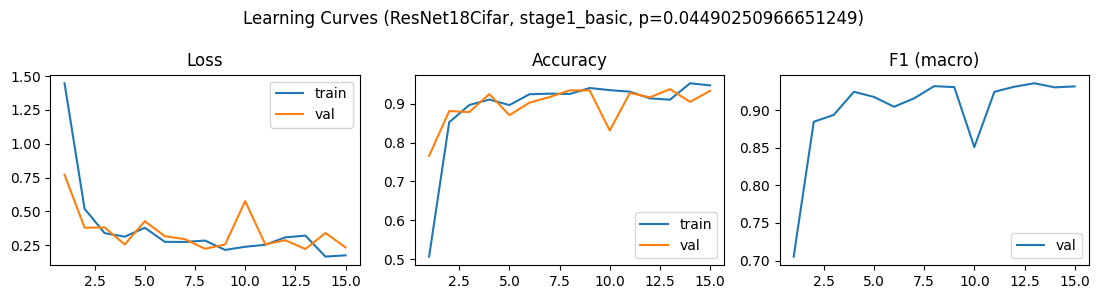

In [30]:
plot_learning_curves(history, f"Learning Curves (ResNet18Cifar, {best_stage}, p={best_p})")

Для ResNet18Cifar с `stage1_basic` и `p_aug` $\approx$ 0.045 loss на train/val в целом убывает, а accuracy и F1 на валидации быстро выходят к ~0.92–0.95 и остаются почти все время на плато

## Часть 7. Knowledge Distillation: ResNet18Cifar -> SimpleCNN

### Выбор лучшего teacher (ResNet18Cifar) для дистилляции

Собираю все запуски ResNet из `reports`:

- Для каждой конфигурации (`stage`, `p_aug`) остается запись с максимальным числом эпох
- Выбирается teacher‑модель с максимальным F1_macro

In [ ]:
def collect_resnet_runs(filter_full=True):
    rows = []
    for p in Path(REPORTS_DIR).glob("resnet18cifar*_metrics.json"):
        m = json.loads(p.read_text())
        s = p.stem

        st = re.search(r"stage_(.+?)_p", s)
        ra = re.search(r"_p(\d+\.\d+)", s)

        rows.append({
            "cfg_id": s.replace("_metrics",""),
            "f1": m.get("f1_macro"),
            "epochs": m.get("epochs"),
            "stage": st.group(1) if st else m.get("stage"),
            "p_aug": float(ra.group(1)) if ra else m.get("p_aug"),
            "mtime": p.stat().st_mtime,
        })
    df = pd.DataFrame(rows).dropna(subset=["f1"])
    if filter_full:
        df = (df.sort_values(["epochs","mtime"])
                .groupby(["stage","p_aug"], as_index=False).tail(1))
    return df

df_all = collect_resnet_runs(filter_full=False) 
best_row = df_all.sort_values("f1", ascending=False).iloc[0]
cfg_id_teacher = best_row["cfg_id"]
best_stage = best_row["stage"]
best_ratio = best_row["p_aug"]

print("Chosen teacher:", cfg_id_teacher, best_stage, best_ratio, best_row["f1"])

Chosen teacher: resnet18cifar_full_stage_stage1_basic_p0.04 stage1_basic 0.04 0.931781574788431


In [ ]:
aug_t = stages[best_stage](mean, std)
prob_t = ProbTransform(base_t=eval_t, aug_t=aug_t, p_aug=best_ratio)

train_loader, val_loader, test_loader = get_dataloaders_with_custom_train_transform(
    data_root=str(DATA_DIR),
    train_transform=prob_t,
    eval_transform=eval_t,
    batch_size=BATCH_SIZE,
    val_fraction=VAL_FRACTION,
    seed=RANDOM_SEED,
    num_workers=0,
)

### Загрузка данных и определение KD‑лосса

Используются те же трансформации (`best_stage`, `best_ratio`), что и у teacher

`kd_loss` (knowledge distillation):
- комбинация KL‑дивергенции между soft‑логитами teacher и student (с температурой `T`)
- и обычной cross‑entropy с истинными метками

In [ ]:
def kd_loss(student_logits, teacher_logits, targets, T: float = 4.0, alpha: float = 0.7):
    kd = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction="batchmean"
    ) * (T * T)
    ce = F.cross_entropy(student_logits, targets)
    return alpha * kd + (1.0 - alpha) * ce

def train_kd_resumeable(
    cfg_id_student: str,
    cfg_id_teacher: str,
    train_loader, val_loader, test_loader,
    device, epochs: int = 15, lr: float = 1e-3, wd: float = 1e-4,
    T: float = 4.0, alpha: float = 0.7, full_eval_every: int = 1
):
    ckpt_s = model_path_of(cfg_id_student)
    hpth_s = history_path_of(cfg_id_student)
    mpth_s = metrics_path_of(cfg_id_student)

    if Path(ckpt_s).exists() and Path(hpth_s).exists() and Path(mpth_s).exists():
        student = SimpleCNN(num_classes=10).to(device)
        student.load_state_dict(torch.load(ckpt_s, map_location=device))
        history = load_json(hpth_s)
        metrics = load_json(mpth_s)
        return student, history, metrics

    teacher = ResNet18Cifar(num_classes=10).to(device)
    teacher_ckpt = model_path_of(cfg_id_teacher)
    teacher.load_state_dict(torch.load(teacher_ckpt, map_location=device))
    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    student = SimpleCNN(num_classes=10).to(device)
    opt = torch.optim.Adam(student.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    history = {"train":{"loss":[],"accuracy":[]}, "val":{"loss":[],"accuracy":[],"f1_macro":[]}}
    best_score, best_state = -1.0, None

    for ep in range(1, epochs+1):
        student.train()
        total_loss=0.0; total_ok=0; total_n=0
        for x,y in train_loader:
            x=x.to(device, non_blocking=True); y=y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.no_grad():
                t_logits = teacher(x)
            s_logits = student(x)
            loss = kd_loss(s_logits, t_logits, y, T=T, alpha=alpha)
            loss.backward(); opt.step()
            total_loss += loss.item()*y.size(0)
            total_ok += (s_logits.argmax(1)==y).sum().item()
            total_n += y.size(0)

        tr_loss = total_loss/max(1,total_n); tr_acc = total_ok/max(1,total_n)
        history["train"]["loss"].append(tr_loss); history["train"]["accuracy"].append(tr_acc)

        @torch.no_grad()
        def _fast_val():
            student.eval()
            tot_l=0.0; ok=0; n=0
            for a,b in val_loader:
                a=a.to(device); b=b.to(device)
                logits = student(a); l = criterion(logits,b)
                tot_l += l.item()*b.size(0); ok += (logits.argmax(1)==b).sum().item(); n += b.size(0)
            return tot_l/max(1,n), ok/max(1,n)

        v_loss, v_acc = _fast_val()
        history["val"]["loss"].append(v_loss); history["val"]["accuracy"].append(v_acc)

        if (ep % full_eval_every == 0) or (ep==epochs):
            v_metrics,_,_ = eval_epoch(student, val_loader, device, criterion)
            history["val"]["f1_macro"].append(v_metrics["f1_macro"])
            score = v_metrics["f1_macro"]
        else:
            history["val"]["f1_macro"].append(float("nan"))
            score = v_acc

        if score > best_score:
            best_score = score
            best_state = {k:v.detach().cpu() for k,v in student.state_dict().items()}

        print(f"Epoch {ep:02d} | Train loss={tr_loss:.4f} acc={tr_acc:.4f} | Val loss={v_loss:.4f} acc={v_acc:.4f} f1={history['val']['f1_macro'][-1]}")

    if best_state is not None:
        student.load_state_dict(best_state)

    test_metrics, y_true, y_pred, cm = evaluate(student, test_loader, device, criterion)
    torch.save(student.state_dict(), ckpt_s)
    save_json(history, hpth_s)

    params_m = sum(p.numel() for p in student.parameters())/1e6
    student.eval()
    torch.mps.empty_cache() if device.type=="mps" else None
    t0=time.time()
    nimg=0
    with torch.no_grad():
        for a,_ in test_loader:
            a=a.to(device)
            _ = student(a)
            nimg += a.size(0)
    ips = nimg/(time.time()-t0)

    test_metrics.update({
        "model_name": "simplecnn_kd",
        "epochs": epochs,
        "params_m": round(params_m,3),
        "infer_img_per_s": round(ips,1)
    })
    save_json(test_metrics, mpth_s)
    return student, history, test_metrics

### Обучение студента SimpleCNN с дистилляцией и сравнение с teacher

`train_kd_resumeable`:
- загружает веса teacher ResNet18Cifar
- обучает студента SimpleCNN с KD‑лоссом
- сохраняет историю, финальные метрики и примерную скорость инференса

In [ ]:
cfg_id_teacher = f"resnet18cifar_full_stage_{best_stage}_p{best_ratio:.2f}"
cfg_id_student = f"simplecnn_kd_stage_{best_stage}_p{best_ratio:.2f}_e15_T4_a0.7"

student, hist_kd, metrics_kd = train_kd_resumeable(
    cfg_id_student, cfg_id_teacher,
    train_loader, val_loader, test_loader,
    device, epochs=15, lr=LR, wd=WEIGHT_DECAY,
    T=4.0, alpha=0.7, full_eval_every=1
)
print("Student KD — Test F1_macro:", round(metrics_kd["f1_macro"],4))
teacher_metrics = load_json(metrics_path_of(cfg_id_teacher))
print("Teacher — Test F1_macro:", round(teacher_metrics["f1_macro"],4))

Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01 | Train loss=5.4551 acc=0.4024 | Val loss=1.8227 acc=0.4912 f1=0.3728232051422533


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 02 | Train loss=2.6401 acc=0.7354 | Val loss=0.5686 acc=0.8326 f1=0.8232950998658797


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 03 | Train loss=1.6105 acc=0.8352 | Val loss=0.4050 acc=0.8767 f1=0.8713519049557332


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 04 | Train loss=1.3629 acc=0.8372 | Val loss=0.4781 acc=0.8531 f1=0.8555886440524887


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 05 | Train loss=1.1330 acc=0.8837 | Val loss=0.3384 acc=0.9006 f1=0.8969291188323133


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 06 | Train loss=1.0216 acc=0.8911 | Val loss=0.3570 acc=0.8913 f1=0.8860289879536977


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 07 | Train loss=0.9689 acc=0.8901 | Val loss=0.3120 acc=0.9035 f1=0.8986350518345306


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 08 | Train loss=0.8892 acc=0.9007 | Val loss=0.2854 acc=0.9121 f1=0.9100548938421392


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 09 | Train loss=0.8393 acc=0.9009 | Val loss=0.2613 acc=0.9199 f1=0.9166854406185436


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 | Train loss=0.8019 acc=0.9014 | Val loss=0.2658 acc=0.9205 f1=0.9166848636980086


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 | Train loss=0.7585 acc=0.9132 | Val loss=0.2518 acc=0.9263 f1=0.9231543920442824


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 | Train loss=0.7475 acc=0.9064 | Val loss=0.3419 acc=0.8965 f1=0.892193428473273


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 | Train loss=0.7109 acc=0.9153 | Val loss=0.2560 acc=0.9220 f1=0.920165898143598


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 | Train loss=0.6846 acc=0.9187 | Val loss=0.2433 acc=0.9274 f1=0.9239357438796796


Val:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 | Train loss=0.6672 acc=0.9164 | Val loss=0.2667 acc=0.9219 f1=0.9192563664483112


Val:   0%|          | 0/68 [00:00<?, ?it/s]

Student KD — Test F1_macro: 0.9307
Teacher — Test F1_macro: 0.9318


In [ ]:
rows = []
rows.append({
    "model":"ResNet18Cifar (teacher)",
    "stage": best_stage, "p_aug": best_ratio,
    "f1_macro": teacher_metrics["f1_macro"],
    "params_m": teacher_metrics.get("params_m"),
    "infer_img_per_s": teacher_metrics.get("infer_img_per_s")
})
rows.append({
    "model":"SimpleCNN (KD student)",
    "stage": best_stage, "p_aug": best_ratio,
    "f1_macro": metrics_kd["f1_macro"],
    "params_m": metrics_kd["params_m"],
    "infer_img_per_s": metrics_kd["infer_img_per_s"]
})
df_kd = pd.DataFrame(rows)
display(df_kd)

,model,stage,p_aug,f1_macro,params_m,infer_img_per_s
0,ResNet18Cifar (teacher),stage1_basic,0.04,0.931782,11.174,NaN
1,SimpleCNN (KD student),stage1_basic,0.04,0.930707,0.141,5366.0


Видно, что компактная модель после дистилляции достигает качества, близкого к teacher при меньших ресурсах